In [69]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn models and utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# XGBoost
from xgboost import XGBClassifier

# Visualization style
sns.set(style="whitegrid")


In [70]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Paths for train and test
train_path = '/content/drive/MyDrive/train.csv'
test_path  = '/content/drive/MyDrive/test.csv'

In [41]:
# Load datasets
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [42]:
# Display info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (614, 13)
Test shape: (367, 12)


In [72]:
# First few rows of train set
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [44]:
# First few rows of train set
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [74]:
# Missing values check
print("Missing values in Training Set:")
print(train_df.isnull().sum())

print("\nMissing values in Testing Set:")
print(test_df.isnull().sum())


Missing values in Training Set:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Missing values in Testing Set:
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


In [75]:
# Copy data to avoid modifying original
train = train_df.copy()
test = test_df.copy()

# Replace '3+' in Dependents
for df in [train, test]:
    df['Dependents'] = df['Dependents'].replace('3+', '3')

# Categorical & numerical columns
cat_cols = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']

# Fill missing values
for col in cat_cols:
    mode_val = train[col].mode()[0]
    train[col].fillna(mode_val, inplace=True)
    test[col].fillna(mode_val, inplace=True)

for col in num_cols:
    med_val = train[col].median()
    train[col].fillna(med_val, inplace=True)
    test[col].fillna(med_val, inplace=True)

# Feature Engineering
for df in [train, test]:
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
    df['LoanToIncomeRatio'] = df['LoanAmount'] / df['TotalIncome']
    df['LoanAmount_log'] = np.log1p(df['LoanAmount'])
    df['TotalIncome_log'] = np.log1p(df['TotalIncome'])

# Drop Loan_ID (keep for submission)
test_ids = test['Loan_ID']
train = train.drop('Loan_ID', axis=1)
test = test.drop('Loan_ID', axis=1)


In [76]:
# Map target
train['Loan_Status'] = train['Loan_Status'].map({'Y':1,'N':0})

# Convert Dependents to numeric
train['Dependents'] = train['Dependents'].astype(float)
test['Dependents'] = test['Dependents'].astype(float)

# One-hot encoding for categorical variables
train_enc = pd.get_dummies(train, drop_first=True)
test_enc = pd.get_dummies(test, drop_first=True)

# Align columns
train_enc, test_enc = train_enc.align(test_enc, join='left', axis=1, fill_value=0)


In [77]:
# Features and target
X = train_enc.drop('Loan_Status', axis=1)
y = train_enc['Loan_Status']

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


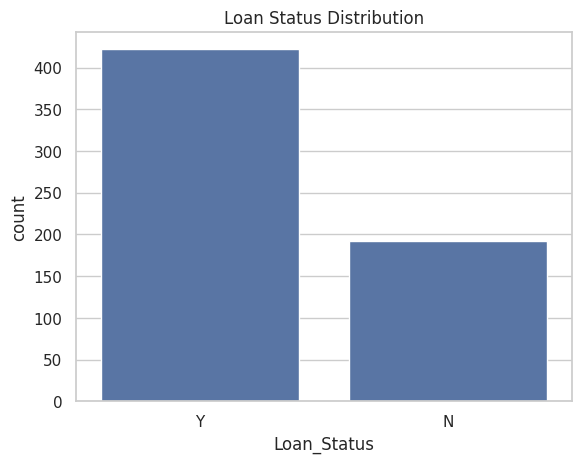

In [80]:
sns.countplot(x='Loan_Status', data=train_df)
plt.title("Loan Status Distribution")
plt.show()

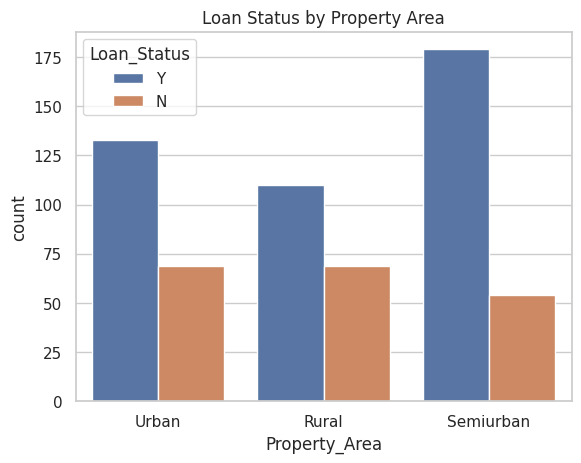

In [81]:
sns.countplot(x='Property_Area', hue='Loan_Status', data=train_df)
plt.title("Loan Status by Property Area")
plt.show()

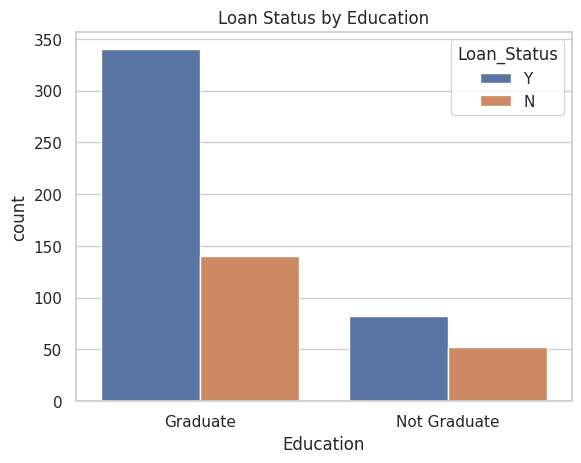

In [83]:
sns.countplot(x='Education', hue='Loan_Status', data=train_df)
plt.title("Loan Status by Education")
plt.show()

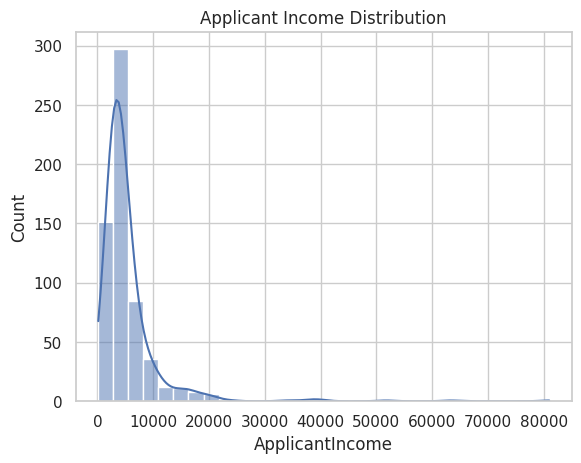

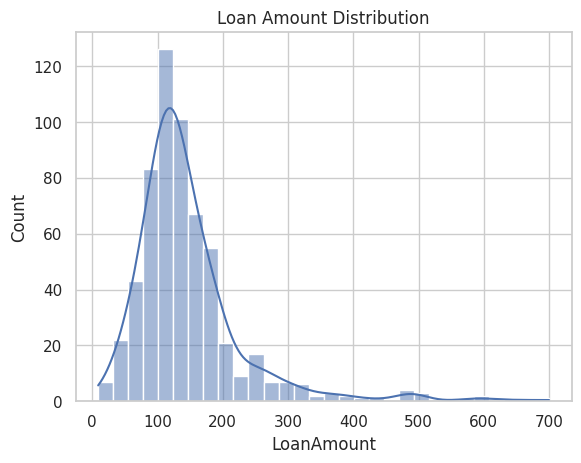

In [84]:
sns.histplot(train_df['ApplicantIncome'], kde=True, bins=30)
plt.title("Applicant Income Distribution")
plt.show()

sns.histplot(train_df['LoanAmount'], kde=True, bins=30)
plt.title("Loan Amount Distribution")
plt.show()

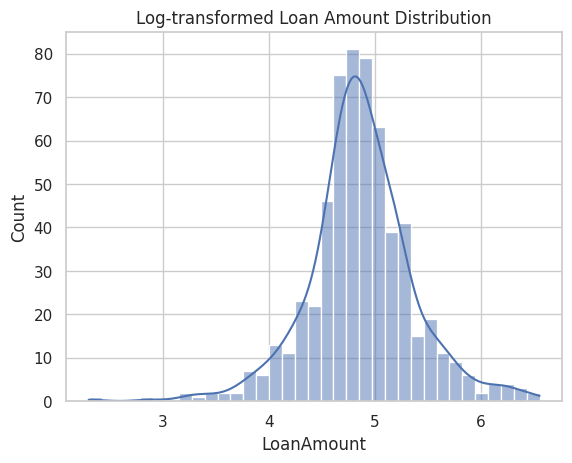

In [85]:
sns.histplot(np.log1p(train_df['LoanAmount']), kde=True)
plt.title("Log-transformed Loan Amount Distribution")
plt.show()

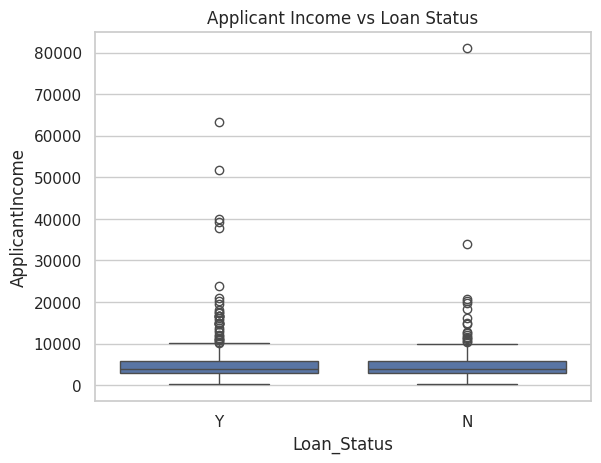

In [86]:
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=train_df)
plt.title("Applicant Income vs Loan Status")
plt.show()

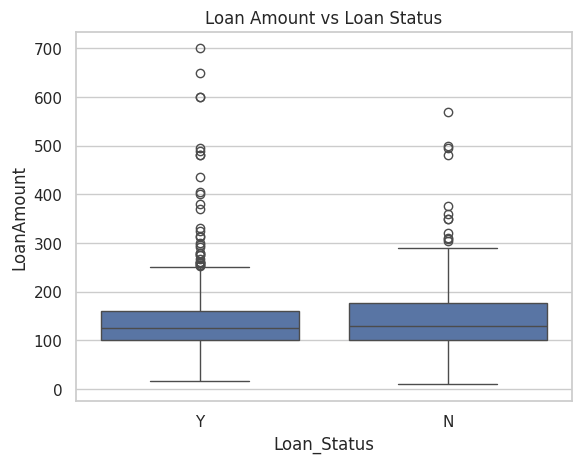

In [87]:
sns.boxplot(x='Loan_Status', y='LoanAmount', data=train_df)
plt.title("Loan Amount vs Loan Status")
plt.show()

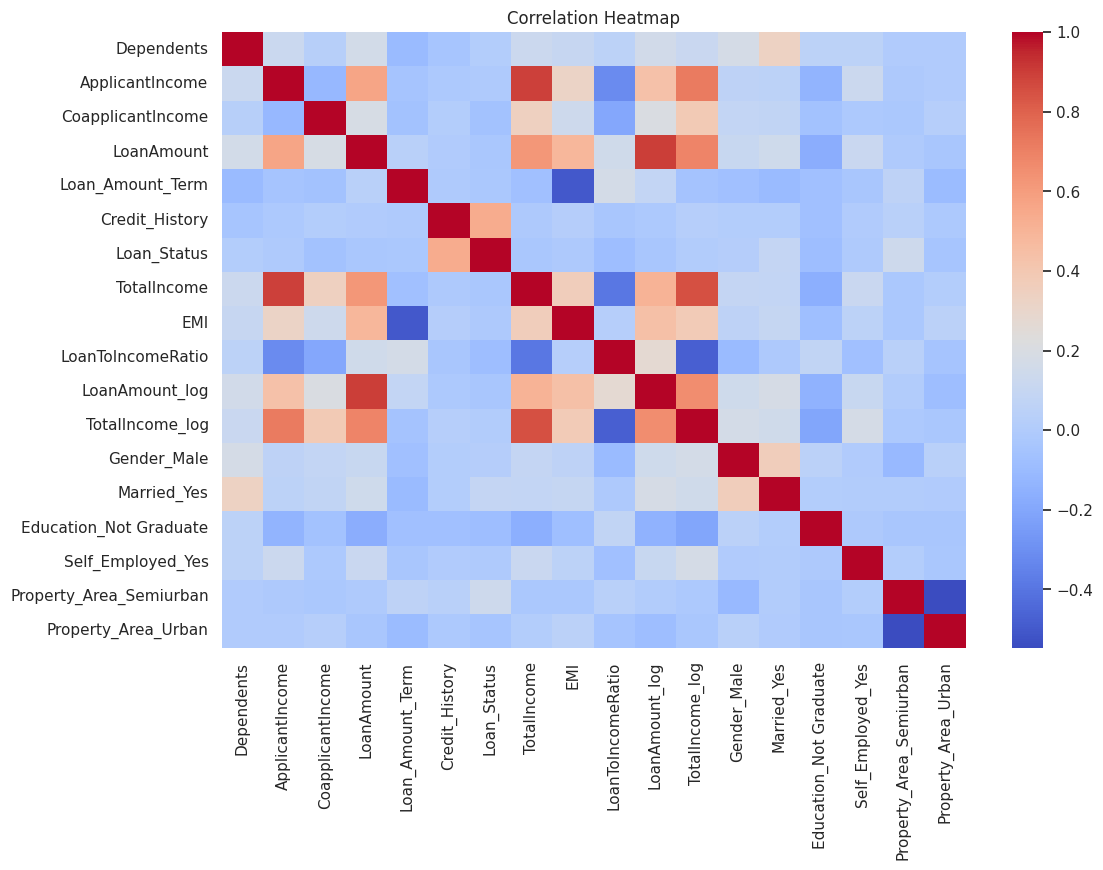

In [88]:
plt.figure(figsize=(12,8))
sns.heatmap(train_enc.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

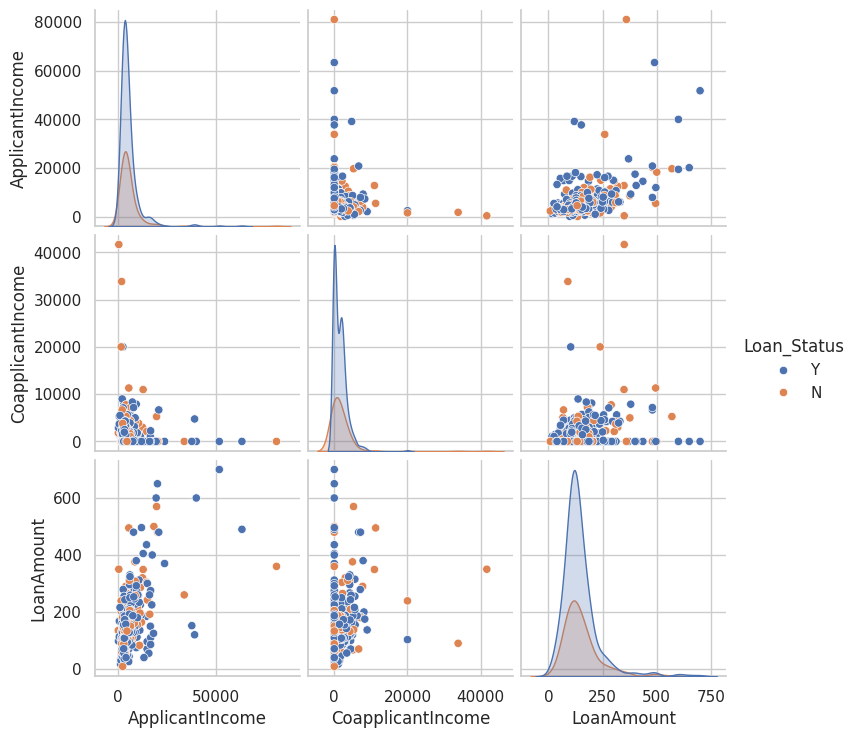

In [89]:
sns.pairplot(train_df, hue='Loan_Status', vars=['ApplicantIncome','CoapplicantIncome','LoanAmount'])
plt.show()

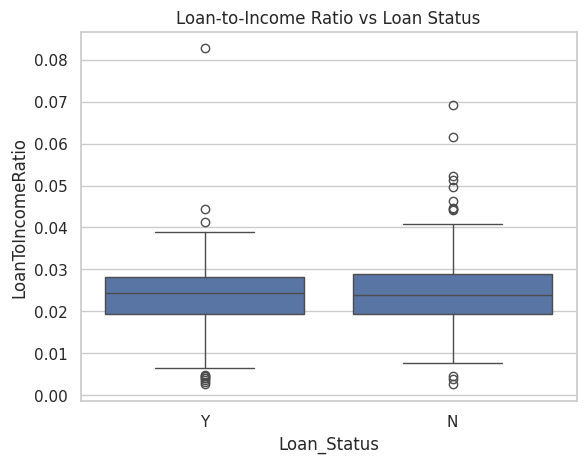

In [90]:
train_df['TotalIncome'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']
train_df['LoanToIncomeRatio'] = train_df['LoanAmount'] / train_df['TotalIncome']

sns.boxplot(x='Loan_Status', y='LoanToIncomeRatio', data=train_df)
plt.title("Loan-to-Income Ratio vs Loan Status")
plt.show()

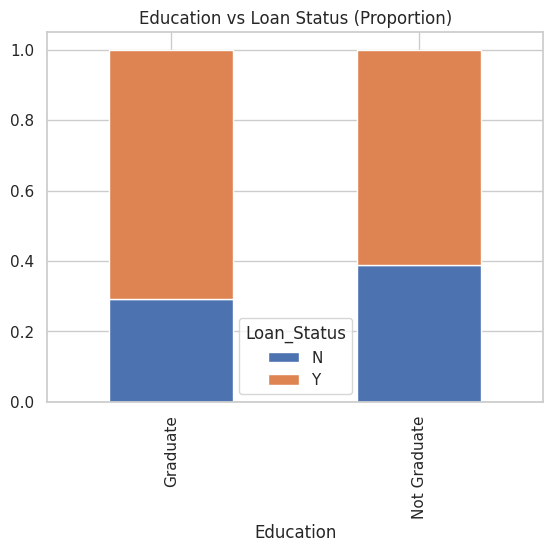

In [91]:
prop_df = pd.crosstab(train_df['Education'], train_df['Loan_Status'], normalize='index')
prop_df.plot(kind='bar', stacked=True)
plt.title("Education vs Loan Status (Proportion)")
plt.show()

In [78]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)  # tree models don't need scaling

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

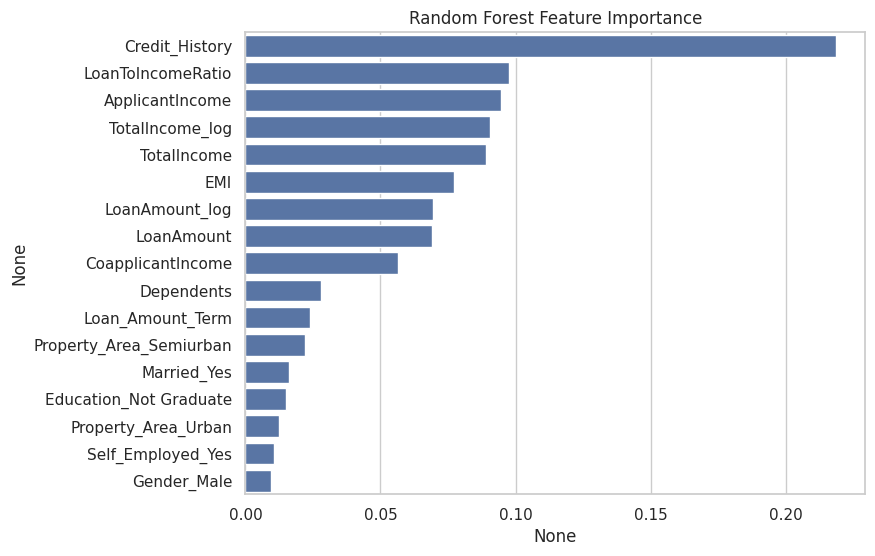

In [92]:
importances = rf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Random Forest Feature Importance")
plt.show()


--- Logistic Regression ---
Accuracy: 0.8699186991869918
ROC AUC : 0.8721362229102168
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.61      0.74        38
           1       0.85      0.99      0.91        85

    accuracy                           0.87       123
   macro avg       0.90      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123



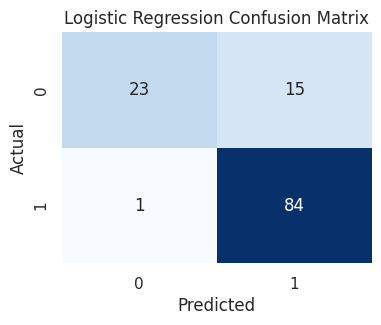

--- Decision Tree ---
Accuracy: 0.7479674796747967
ROC AUC : 0.7230650154798761
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.66      0.62        38
           1       0.84      0.79      0.81        85

    accuracy                           0.75       123
   macro avg       0.71      0.72      0.71       123
weighted avg       0.76      0.75      0.75       123



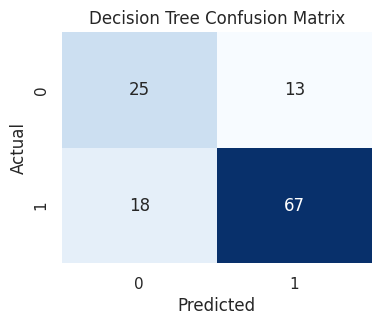

--- Random Forest ---
Accuracy: 0.8699186991869918
ROC AUC : 0.8561919504643963
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77        38
           1       0.88      0.94      0.91        85

    accuracy                           0.87       123
   macro avg       0.86      0.83      0.84       123
weighted avg       0.87      0.87      0.87       123



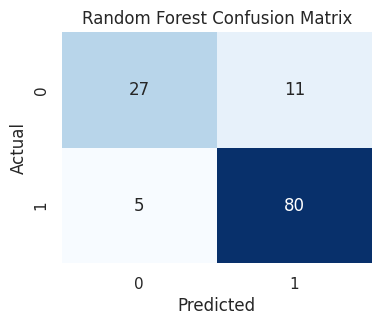

--- XGBoost ---
Accuracy: 0.8211382113821138
ROC AUC : 0.8089783281733746
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.69        38
           1       0.85      0.89      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.78      0.78       123
weighted avg       0.82      0.82      0.82       123



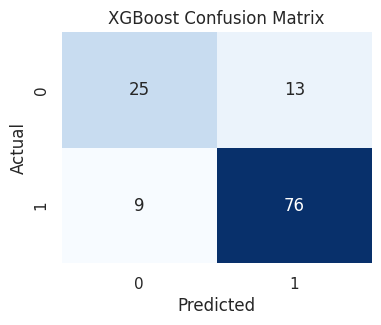

,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.869919,0.872136
2,Random Forest,0.869919,0.856192
3,XGBoost,0.821138,0.808978
1,Decision Tree,0.747967,0.723065


In [93]:
models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb}
preds_scaled = [True, False, False, False]  # only LR uses scaled features

results = []

for i, (name, model) in enumerate(models.items()):
    X_val_input = X_val_scaled if preds_scaled[i] else X_val
    y_pred = model.predict(X_val_input)
    y_proba = model.predict_proba(X_val_input)[:,1]

    acc = accuracy_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_proba)

    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("ROC AUC :", roc)
    print("Classification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    results.append([name, acc, roc])

# Summary table
results_df = pd.DataFrame(results, columns=['Model','Accuracy','ROC_AUC']).sort_values(by='Accuracy', ascending=False)
display(results_df)


In [94]:
# Choose best model (Random Forest here)
best_model = rf

# Ensure test features match training features
X_test_final = test_enc[X.columns]  # align columns

# Predict
test_preds = best_model.predict(X_test_final)

# Map numeric back to 'Y'/'N'
test_preds_label = pd.Series(test_preds).map({1:'Y',0:'N'})

# Submission
submission = pd.DataFrame({'Loan_ID': test_ids, 'Loan_Status': test_preds_label})
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print("Submission saved:", submission_path)
submission.head()


Submission saved: submission.csv


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
